In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# 加载MNIST数据集
#对数据进行预处理
transform = transforms.Compose([
    transforms.Resize(224),#resize到224*224
    transforms.ToTensor(),#转化成张量（Tensor）
    transforms.Normalize((0.1307,), (0.3081,))#左均值，右标准差，标准化
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

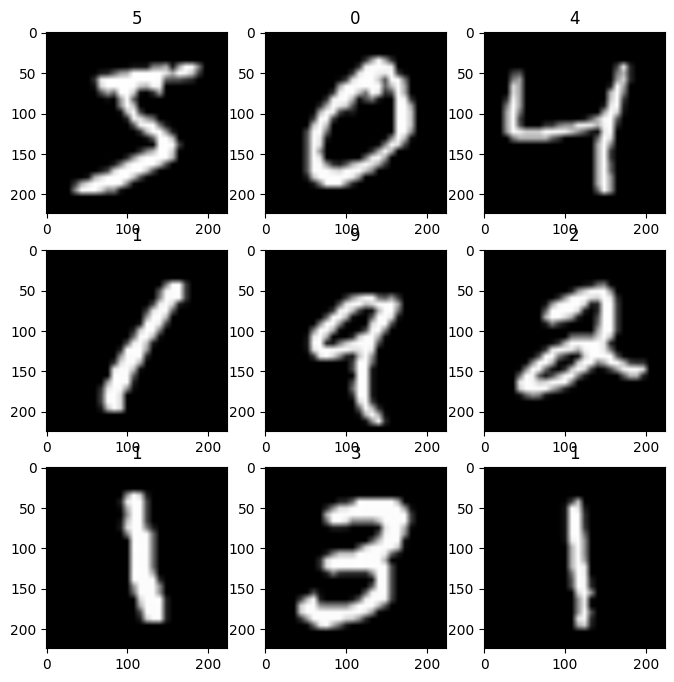

In [3]:
# 随机展示训练集中的九张图片
figure = plt.figure(figsize=(8, 8))
sample_idx = torch.randint(len(train_dataset), size=(9,))
row, column = 0, 0
for i, pict_index in enumerate(sample_idx):
    img, label = train_dataset[i]
    figure.add_subplot(3, 3, i + 1)
    plt.title(str(label))
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
# 定义AlexNet模型结构
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        #5个卷积层
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        #3个全连接层
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    #前向传播
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
# 设置超参数
learning_rate = 0.001
num_epochs = 10
step_size = 2  # 每两次迭代降低一次学习率
gamma = 0.5  # 学习率降低到原来的0.5倍

# 初始化模型、损失函数和优化器
model = AlexNet(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 创建学习率调度器
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [6]:
# 训练模型
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = train_correct / total
    train_accuracies.append(train_accuracy)
    
    scheduler.step()  # 更新学习率
    
    model.eval()
    test_loss = 0
    test_correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            test_correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            all_preds.extend(pred.view(-1).tolist())
            all_targets.extend(target.view(-1).tolist())
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = test_correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1, Train Loss: 0.3317, Train Accuracy: 0.8883, Test Loss: 0.0606, Test Accuracy: 0.9806
Epoch 2, Train Loss: 0.0762, Train Accuracy: 0.9770, Test Loss: 0.0342, Test Accuracy: 0.9889
Epoch 3, Train Loss: 0.0400, Train Accuracy: 0.9882, Test Loss: 0.0248, Test Accuracy: 0.9916
Epoch 4, Train Loss: 0.0342, Train Accuracy: 0.9897, Test Loss: 0.0207, Test Accuracy: 0.9940
Epoch 5, Train Loss: 0.0221, Train Accuracy: 0.9930, Test Loss: 0.0152, Test Accuracy: 0.9950
Epoch 6, Train Loss: 0.0182, Train Accuracy: 0.9944, Test Loss: 0.0181, Test Accuracy: 0.9953
Epoch 7, Train Loss: 0.0121, Train Accuracy: 0.9964, Test Loss: 0.0163, Test Accuracy: 0.9945
Epoch 8, Train Loss: 0.0106, Train Accuracy: 0.9965, Test Loss: 0.0182, Test Accuracy: 0.9941
Epoch 9, Train Loss: 0.0079, Train Accuracy: 0.9976, Test Loss: 0.0172, Test Accuracy: 0.9949
Epoch 10, Train Loss: 0.0076, Train Accuracy: 0.9976, Test Loss: 0.0169, Test Accuracy: 0.9950


In [7]:
# 计算测试集上的指标
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='macro')
recall = recall_score(all_targets, all_preds, average='macro')
f1 = f1_score(all_targets, all_preds, average='macro')
conf_matrix = confusion_matrix(all_targets, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.9950
Precision: 0.9950
Recall: 0.9949
F1-Score: 0.9949
Confusion Matrix:
[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1133    1    1    0    0    0    0    0    0]
 [   0    0 1028    0    0    0    0    3    1    0]
 [   0    0    0 1007    0    3    0    0    0    0]
 [   0    0    0    0  977    0    1    0    0    4]
 [   1    0    0    6    0  884    1    0    0    0]
 [   2    3    0    0    1    2  949    0    1    0]
 [   0    2    0    0    0    0    0 1025    1    0]
 [   1    0    1    1    0    0    0    0  970    1]
 [   0    0    0    0    4    2    0    2    2  999]]


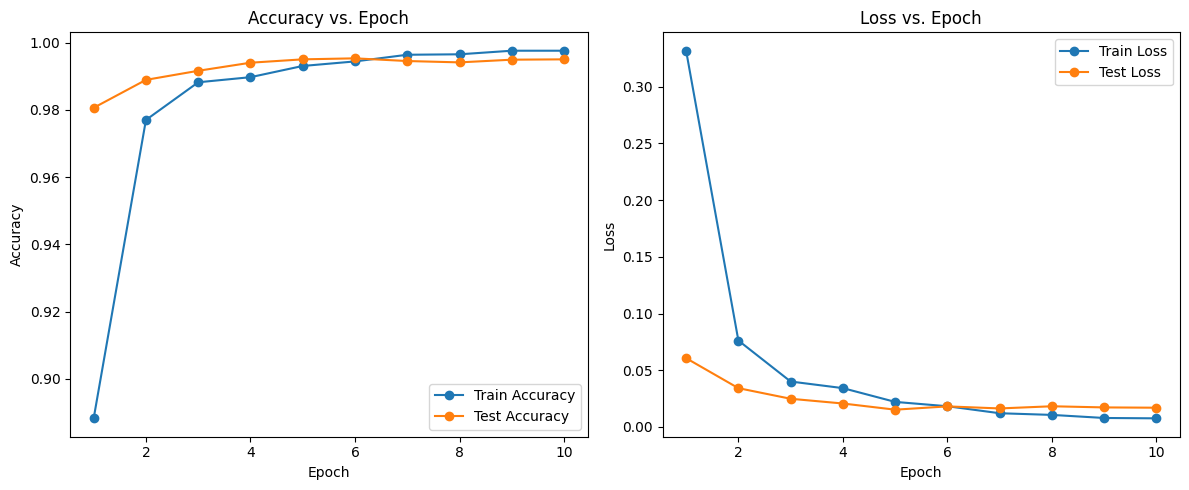

In [8]:
# 画出accuracy和loss的图像
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()